3D slicc preprocessing

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import skimage.segmentation
#from fast_slic import Slic
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.filters import threshold_otsu
from skimage.filters import median
from skimage.color import rgb2gray
from scipy.stats import ttest_ind, norm

In [45]:
print( skimage.__version__)

0.14.2


In [46]:
def evaluate_segmentation(seg_hat_flat, seg_flat, tumor_label):
    #coordinates of predicted and actual tumor
    y_coors = np.argwhere(seg_flat!=0)

    yhat_coors = np.argwhere(seg_hat_flat ==tumor_label)

    #size of tumor and non-tumor (number of voxels)
    tumor_size=len(y_coors)
    total_size = len(seg_flat)
    non_tumor_size = total_size-tumor_size


    #true positive
    correct_id_tumor = np.intersect1d(y_coors, yhat_coors)

    
    
    percent_tumor_correct = len(correct_id_tumor)/tumor_size

    #false positive
    false_positive_points = np.setdiff1d(yhat_coors, y_coors)
    false_positive = len(false_positive_points)/non_tumor_size

    #false negative
    false_neg_points = np.setdiff1d(y_coors, yhat_coors)
    false_neg = len(false_neg_points)/tumor_size

    
    #true negative
    true_negative=(total_size-(tumor_size+len(false_positive_points)))/non_tumor_size

    #Total error (misidentification
    total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))
    total_error = len(total_incorrect_points)/total_size
    
    #percentage of yhat that is correct
    yhat_size = len(yhat_coors)
    correct_id_tumor_hat = np.intersect1d(yhat_coors, y_coors)
    specificity = len(correct_id_tumor_hat)/yhat_size
    
    #New metric, TP + specificity
    metric = (percent_tumor_correct + specificity)/2
    
    print("True Positive: ", percent_tumor_correct)
    print("False negative: ", false_neg)
    print("True Negative: ", true_negative)
    print("False Positive: ", false_positive)
    print("'specificity':", specificity)
    print("metric: ", metric)
    
    print("************")
    print("Total Error: ", total_error)

# Load MRI data

In [47]:
sample_flair_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_flair.nii"
sample_seg_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_seg.nii"


In [48]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [49]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)

# Basic preprocessing, need RGB for slicc to work

In [50]:
#normalize
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)
flair_norm = (flair_norm*255).astype(np.uint8) #normalize so we don't get conversion issures
#median filter (noise reduction)
#flair_norm  = median(flair_norm, behavior='ndimage' )
maxval

1019

In [51]:
np.unique(flair_norm*255)

array([  0,   1,   8,   9,  10,  11,  13,  17,  18,  20,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 19

In [52]:
#convert to rGB color space 
flair_rgb = gray2rgb(flair_norm )
flair_rgb[100,100,60,:]

array([72, 72, 72], dtype=uint8)

# Segment whole MRI using 2D superpixel slices

In [55]:
tolerance = 0.1
output = np.zeros(data_flair.shape)
for i in range(0, data_flair.shape[2]):
    slice_2d = flair_norm[:,:,i]
    slice_2d=median(slice_2d)

    slice_2d=gray2rgb(slice_2d)

#    if maxval > tolerance: #otherwise assume image has no tumor
    n_segments_2d = 300
    slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, convert2lab=True)
    slice_2d = rgb2gray(slice_2d)
    print(np.unique(slice_2d))
    
    

    
    
    labels2D = np.unique(slic_mask_2d)


    for label in labels2D:
        slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])

    output[:,:,i]=slice_2d



cluster_3d_masked = output[output > tolerance]

thresh_3d = threshold_otsu(cluster_3d_masked.flatten())
print(thresh_3d)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()




[0.         0.01568627 0.04313725 0.0627451  0.09803922 0.10980392
 0.16470588 0.18039216 0.19607843 0.20392157 0.20784314 0.21176471
 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255 0.23921569
 0.24313725 0.24705882 0.25098039 0.25490196 0.25882353 0.2627451
 0.26666667 0.27058824 0.30980392 0.36470588 0.40392157]
[0.         0.05882353 0.06666667 0.0745098  0.09411765 0.09803922
 0.10980392 0.11764706 0.12156863 0.12941176 0.14117647 0.14509804
 0.14901961 0.15294118 0.15686275 0.16470588 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.29019608]
[0.         0.03529412 0.04313725 0.04705882 0.0627451  0.06666667
 0.0745098  0.07843137 0.08235294 0.09019608 0.09411765 0.09803922
 0.10196078 0.10980392 0.11372549 0.11764706 0.12156863 0.12

[0.         0.02745098 0.03529412 0.03921569 0.04313725 0.04705882
 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667 0.07058824
 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608 0.09411765
 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549 0.11764706
 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549  0.14117647
 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431 0.16470588
 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373 0.18823529
 0.19215686 0.19607843 0.2        0.20392157 0.20784314 0.21176471
 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412
 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196 0.25882353
 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137 0.28235294
 0.29019608 0.29411765 0.29803922 0.30196078 0.30588235 0.31372549
 0.32156863 0.34117647 0.34509804 0.36078431 0.36862745 0.37254902
 0.40392157]
[0.         0.01960784 0.02352941 0.02745098 0.03137255 0.03529412
 0.03921569 0.04313725 0.04705882 0.05098039 0.05

[0.         0.00784314 0.01176471 0.01568627 0.01960784 0.02352941
 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725 0.04705882
 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667 0.07058824
 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608 0.09411765
 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549 0.11764706
 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549  0.14117647
 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431 0.16470588
 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373 0.18823529
 0.19215686 0.19607843 0.2        0.20392157 0.20784314 0.21176471
 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412
 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196 0.25882353
 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137 0.28235294
 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078 0.30588235
 0.30980392 0.31372549 0.31764706 0.32156863 0.3254902  0.32941176
 0.33333333 0.3372549  0.34117647 0.34509804 0.34901961 0.3529

[0.         0.00784314 0.01176471 0.01568627 0.01960784 0.02352941
 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725 0.04705882
 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667 0.07058824
 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608 0.09411765
 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549 0.11764706
 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549  0.14117647
 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431 0.16470588
 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373 0.18823529
 0.19215686 0.19607843 0.2        0.20392157 0.20784314 0.21176471
 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412
 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196 0.25882353
 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137 0.28235294
 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078 0.30980392
 0.31372549 0.32156863 0.34117647 0.34901961]
[0.         0.00392157 0.01568627 0.01960784 0.02352941 0.02745098
 0.03137255 0.03

KeyboardInterrupt: 

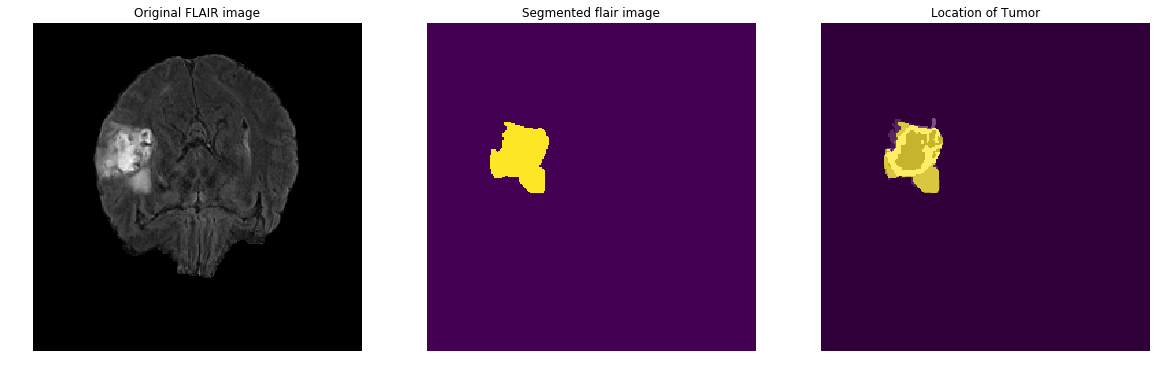

In [54]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [25]:
evaluate_segmentation(output.flatten(), data_seg.flatten(), tumor_otsu_label)

True Positive:  0.7449587005675788
False negative:  0.2550412994324212
True Negative:  0.9998494033197451
False Positive:  0.00015059668025488432
'specificity': 0.9602093618033665
metric:  0.8525840311854727
************
Total Error:  0.0013879928315412187


# T Test value

In [12]:
tumor_hat = (flair_norm[output>0]).flatten()
nontumor_hat = flair_norm[output ==0]
nontumor_hat = nontumor_hat[nontumor_hat> tolerance]

In [13]:
np.mean(tumor_hat)

0.44683124268319313

In [14]:
np.mean(nontumor_hat)

0.1819344853461763

In [15]:
ttest_ind(tumor_hat, nontumor_hat)

Ttest_indResult(statistic=1225.2852429914374, pvalue=0.0)

In [16]:
mean_diff = np.mean(tumor_hat) - np.mean(nontumor_hat)
mean_diff

0.26489675733701684

# T test with cleaned image

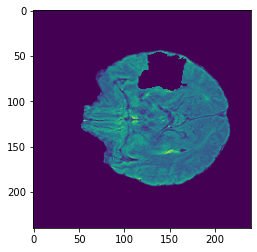

In [17]:
data_flair[data_seg>0]=0
plt.figure()
plt.imshow(data_flair[:,:,60])
plt.show()

In [18]:
#normalize
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)

#median filter (noise reduction)
flair_norm  = median(flair_norm )

#convert to rGB color space
flair_rgb = gray2rgb(flair_norm )

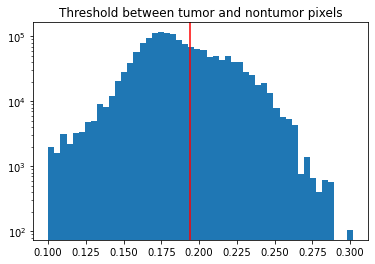

In [19]:
tolerance = 0.1
output = np.zeros(data_flair.shape)
for i in range(0, 155):
    slice_2d = flair_rgb[:,:,i,:]
    maxval = np.max(slice_2d)
    if maxval > tolerance: #otherwise assume image has no tumor
        n_segments_2d = 300
        slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, start_label=1)
        slice_2d = rgb2gray(slice_2d)
        labels2D = np.unique(slic_mask_2d)
        

        for label in labels2D:
            slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])
        output[:,:,i]=slice_2d

         

cluster_3d_masked = output[output > tolerance]

thresh_3d = threshold_otsu(cluster_3d_masked)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()




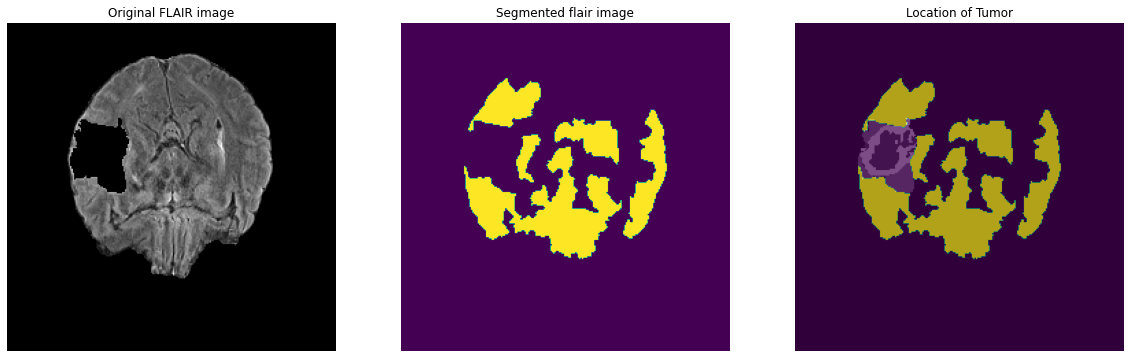

In [20]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [21]:
tumor_hat = (flair_norm[output>0]).flatten()
nontumor_hat = flair_norm[output ==0]
nontumor_hat = nontumor_hat[nontumor_hat> tolerance]

In [22]:
np.mean(tumor_hat)

0.21732506112438293

In [23]:
np.std(tumor_hat)

0.035631273420600976

In [24]:
np.mean(nontumor_hat)

0.17287204797057515

In [25]:
np.std(nontumor_hat)

0.025977374595761164

In [26]:
ttest_ind(tumor_hat, nontumor_hat, equal_var=False)

Ttest_indResult(statistic=830.5226930972153, pvalue=0.0)

In [27]:
mean_diff = np.mean(tumor_hat) - np.mean(nontumor_hat)
mean_diff

0.044453013153807786